# Detecting Gravitional Waves Using Topological algorithms

Authors:
* Christian Jaffé Alarcón Acosta - A00832881
* José Andrés Orantes Guillén - A01174130
* Juan José Montes Raygoza - A00834630
* Pedro Fernández Merino - A01733006
* Rubén Darío Castro Terrazas - A00833945



### Import libraries and dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from data.generate_datasets import make_gravitational_waves
from pathlib import Path
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.cm as cm
import gudhi as gd
from sklearn.decomposition import PCA
from nolitsa import dimension, delay
from gtda.plotting import plot_point_cloud
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
import matplotlib.patches as patches
import kmapper as km
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from persim import plot_diagrams
from ripser import ripser

sb.set(style="whitegrid")
plt.rcParams.update(plt.rcParamsDefault) #Permitir Latex

### Motivation


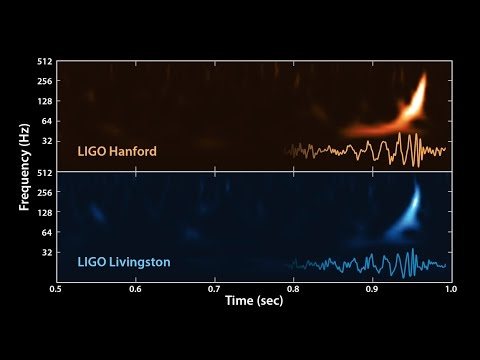

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo("Y3eR49ogsF0", width=600, height=400)
YouTubeVideo("QyDcTbR-kEA", width=600, height=400)

### Generate the data

The data was obtanined from the giotto-tda library: https://github.com/giotto-ai/giotto-tda/blob/master/examples/gravitational_waves_detection.ipynb

In the article, the authors create a synthetic training set as follows: 

* Generate gravitational wave signals that correspond to non-spinning binary black hole mergers
* Generate a noisy time series and embed a gravitational wave signal with probability 0.5 at a random time.

The result is a set of time series of the form

$$ s = g + \epsilon \frac{1}{R}\xi $$

where $g$ is a gravitational wave signal from the reference set, $\xi$ is Gaussian noise, $\epsilon=10^{-19}$ scales the noise amplitude to the signal, and $R \in (0.075, 0.65)$ is a parameter that controls the signal-to-noise-ratio (SNR).

In [62]:

R = 0.65
n_signals = 100
DATA = Path("./data")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 100
Number of timesteps per series: 8692


Plot the data (gravitational waves)

In [63]:
# get the index corresponding to the first pure noise time series
background_idx = np.argmin(labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(labels)

ts_noise = noisy_signals[background_idx]
ts_background = noisy_signals[signal_idx]
ts_signal = gw_signals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise))), y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background))),
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()

In [5]:
ts_signal.shape

(8192,)

In [53]:

initial_segment = ts_signal[:3000]  # Adjust the range according to your data
threshold = max(abs(initial_segment)) * 1.1  # Slightly higher than the max of the initial part

# Find the index where the signal first exceeds the threshold
indices = np.where(abs(ts_signal) > threshold)[0]

# Check if indices is empty
if indices.size > 0:
    cut_off_index = indices[0]
    truncated_signal = ts_signal[:cut_off_index]
else:
    print("No points exceed the threshold")
    truncated_signal = ts_signal  # No truncation if the threshold is not exceeded

ts_signal =  truncated_signal


In [64]:
fig2 = make_subplots(rows=1, cols=1)

fig2.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=1,
)
fig2.show()

### Encaje de Takens

#### Parámetros óptimos de $\tau$ y $d$

* $\tau$: tiempo de retardo
* $d$: dimensión 

In [8]:
ts_noise.shape #dimension de los datos con ruido
max_parameters =  int(round(np.sqrt(ts_noise.shape[0]),0))
max_parameters

93

In [9]:
def find_optimal_delay(x, maxtau):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)
    return int(np.where(diffmi > 0)[0][0]) #returns the first element in which the difference is greater than 0. It means that gives you the local optimal
    #print(np.where(diffmi > 0))

In [10]:
tau_ts_noise  = find_optimal_delay(ts_noise,maxtau=max_parameters) #ejemplo
tau_ts_signal  = find_optimal_delay(ts_signal,maxtau=max_parameters) #ejemplo
print(f'El óptimo local para los datos con ruido es : {tau_ts_noise}')
print(f'El óptimo local para los datos sin ruido es : {tau_ts_signal}')

El óptimo local para los datos con ruido es : 1
El óptimo local para los datos sin ruido es : 29


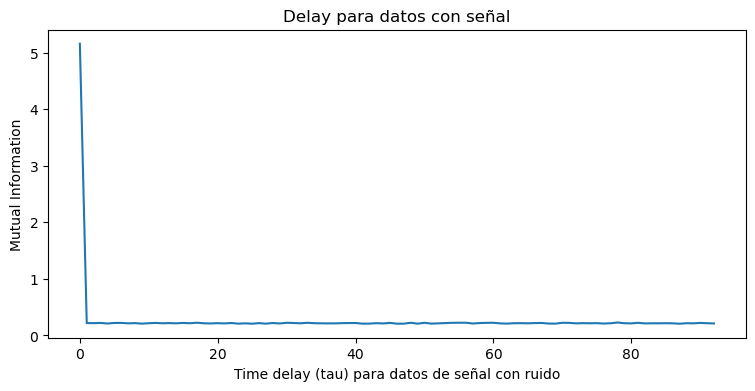

In [11]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau) para datos de señal con ruido')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(ts_noise, maxtau=max_parameters))
plt.title("Delay para datos con señal")
plt.show()

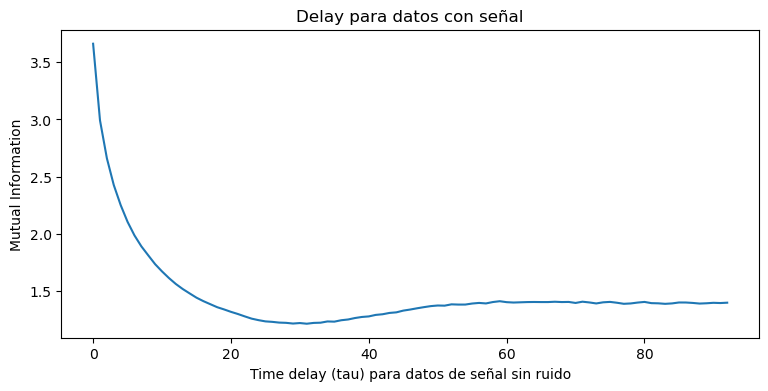

In [12]:
#sin ruido
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau) para datos de señal sin ruido')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(ts_signal, maxtau=max_parameters))
plt.title("Delay para datos con señal")
plt.show()

In [13]:
def find_optimal_dimension(y,tau):
    dim =  np.arange(1,10)
    f1, f2, f3 = dimension.fnn(y, tau=tau, dim=dim)
    diff_f1 = np.diff(f1)
    #print(f1)
    optimal_d = int(np.where(diff_f1 == 0)[0][0]) 

    #changeOf_diff_f1 = np.diff(diff_f1) 
    #optimal_dimension = np.argmax(changeOf_diff_f1) + 2
    return optimal_d


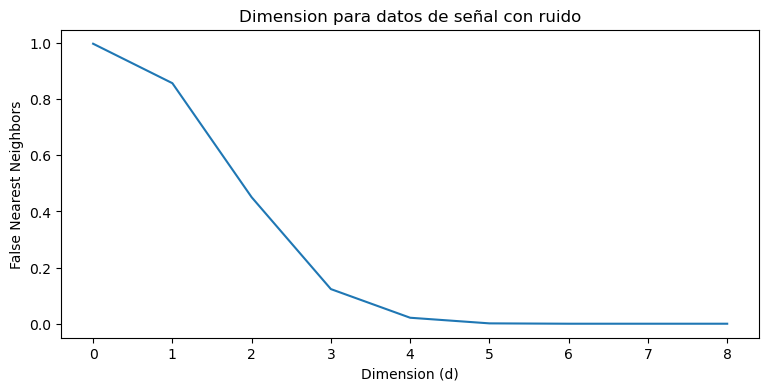

d:  6


In [14]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(ts_noise, tau=tau_ts_noise, dim=dim) #Ejemplo

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors')
plt.title("Dimension para datos de señal con ruido")
plt.plot(f1)
plt.show()
print("d: ",find_optimal_dimension(ts_noise,tau_ts_noise))

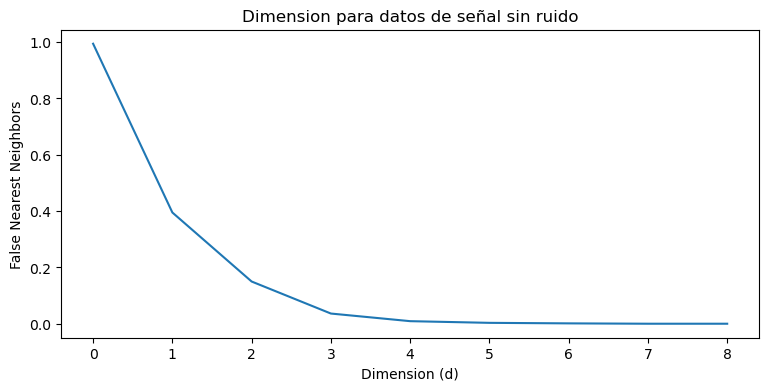

d:  6


In [15]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(ts_signal, tau=tau_ts_signal, dim=dim) #Ejemplo

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors')
plt.title("Dimension para datos de señal sin ruido")
plt.plot(f1)
plt.show()
print("d: ",find_optimal_dimension(ts_noise,tau_ts_noise))

Vamos a elegir la dimension 3.

### Aplicar el Encaje

In [16]:
#Estandarizar datos
from sklearn.preprocessing import StandardScaler

scaler =  StandardScaler()
#scaler.fit(ts_noise.reshape(-1,1))
ts_noise_scaled = scaler.fit_transform(ts_noise.reshape(-1,1))
ts_noise_scaled.shape

(8692, 1)

In [66]:
ts_signal_scaled = scaler.fit_transform(ts_signal.reshape(-1,1))
ts_signal_scaled.shape

(8192, 1)

In [18]:
our_stride = 15
dim =  3

#con ruido
embedder_noise = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=6, time_delay=tau_ts_noise, dimension=2, stride=our_stride
)

y_embedded_noise = embedder_noise.fit_transform(ts_noise_scaled)

In [72]:
#sin ruido
embedder_signal = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay= tau_ts_signal, dimension=2, stride=our_stride
)

y_embedded_signal = embedder_signal.fit_transform(ts_signal_scaled)

In [20]:
y_embedded_noise.shape

(580, 2)

In [21]:
y_embedded_signal.shape

(545, 2)

In [22]:
plot_point_cloud(y_embedded_noise)

In [23]:
ts_signal.shape

(8192,)

In [73]:
plot_point_cloud(y_embedded_signal)

### Analisis de persistencia

In [25]:
result_noise = ripser(y_embedded_noise,maxdim=2)
diagrams_noise = result_noise['dgms']
diagrams_noise

[array([[0.        , 0.00269218],
        [0.        , 0.00296024],
        [0.        , 0.00417186],
        ...,
        [0.        , 0.71015066],
        [0.        , 1.12593687],
        [0.        ,        inf]]),
 array([[0.93236947, 0.95860207],
        [0.55043226, 0.65550566],
        [0.52017558, 0.61697394],
        [0.47375843, 0.54447347],
        [0.4398981 , 0.50600451],
        [0.428148  , 0.53710151],
        [0.42518324, 0.4617928 ],
        [0.41908032, 0.42231527],
        [0.39456311, 0.66971737],
        [0.39306939, 0.52930743],
        [0.3843281 , 0.40153843],
        [0.38016397, 0.38076437],
        [0.37192667, 0.4025138 ],
        [0.37100232, 0.37605479],
        [0.36632505, 0.57087553],
        [0.358962  , 0.39609903],
        [0.33912209, 0.45157114],
        [0.3336651 , 0.33402273],
        [0.3317588 , 0.33840576],
        [0.32936355, 0.37654835],
        [0.32235467, 0.37019527],
        [0.31996635, 0.32317492],
        [0.31943974, 0.34666196],

In [26]:
dmg1_noise=diagrams_noise[1] #datos de B_1
huecos_noise = pd.DataFrame(dmg1_noise, columns=['Birth', 'Death'])
huecos_noise['Life'] = huecos_noise['Death'] - huecos_noise['Birth']
huecos_noise = huecos_noise.sort_values(by='Life', ascending=False)
index =pd.Series(range(len(huecos_noise.index))) #index
huecos_noise['huecos_noise'] = index
huecos_noise.head(10)

,Birth,Death,Life,huecos_noise
8,0.394563,0.669717,0.275154,8
74,0.192968,0.464357,0.271389,74
14,0.366325,0.570876,0.204550,14
45,0.243992,0.407423,0.163431,45
55,0.219981,0.373896,0.153915,55
24,0.303862,0.443320,0.139458,24
9,0.393069,0.529307,0.136238,9
112,0.134682,0.267929,0.133247,112
75,0.192615,0.322215,0.129600,75
66,0.201901,0.331174,0.129273,66


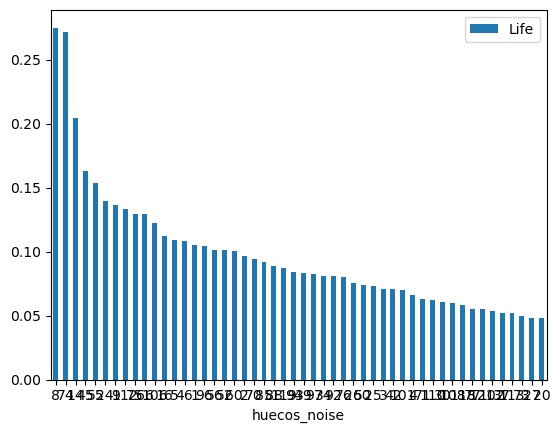

In [75]:
huecos_noise_top10 = huecos_noise.iloc[:50,:]
huecos_noise_top10.plot.bar(x='huecos_noise', y='Life', rot=0) #plot la persistencia de los huecos de la señal con ruido
plt.show()

In [47]:
result_signal = ripser(y_embedded_signal,maxdim=2)
diagrams_signal = result_signal['dgms']
diagrams_signal

[array([[0.        , 0.00061735],
        [0.        , 0.00062914],
        [0.        , 0.00065105],
        [0.        , 0.00067284],
        [0.        , 0.00070791],
        [0.        , 0.00078986],
        [0.        , 0.00120632],
        [0.        , 0.00129639],
        [0.        , 0.00140102],
        [0.        , 0.00146316],
        [0.        , 0.00464727],
        [0.        , 0.01071943],
        [0.        , 0.01124105],
        [0.        , 0.01142953],
        [0.        , 0.01198319],
        [0.        , 0.01245976],
        [0.        , 0.01474713],
        [0.        , 0.02291849],
        [0.        , 0.02777835],
        [0.        , 0.02916283],
        [0.        , 0.03057554],
        [0.        , 0.03124227],
        [0.        , 0.03706408],
        [0.        , 0.0380633 ],
        [0.        , 0.03954189],
        [0.        , 0.04019998],
        [0.        , 0.04036516],
        [0.        , 0.04384033],
        [0.        , 0.04650268],
        [0.   

In [48]:
dmg1_signal = diagrams_signal[1] #datos de B_1
huecos_signal = pd.DataFrame(dmg1_signal, columns=['Birth', 'Death'])
huecos_signal['Life'] = huecos_signal['Death'] - huecos_signal['Birth']
huecos_signal = huecos_signal.sort_values(by='Life', ascending=False)
index =pd.Series(range(len(huecos_signal.index))) #index
huecos_signal['huecos_signal'] = index
huecos_signal.head(10)

,Birth,Death,Life,huecos_signal
14,0.307449,0.722934,0.415485,14
7,0.377441,0.658080,0.280639,7
9,0.343961,0.597381,0.253420,9
12,0.313281,0.481261,0.167980,12
15,0.305715,0.467568,0.161853,15
16,0.296920,0.446788,0.149868,16
21,0.255813,0.393280,0.137468,21
11,0.330558,0.458043,0.127485,11
8,0.357505,0.458782,0.101277,8
10,0.337389,0.435040,0.097650,10


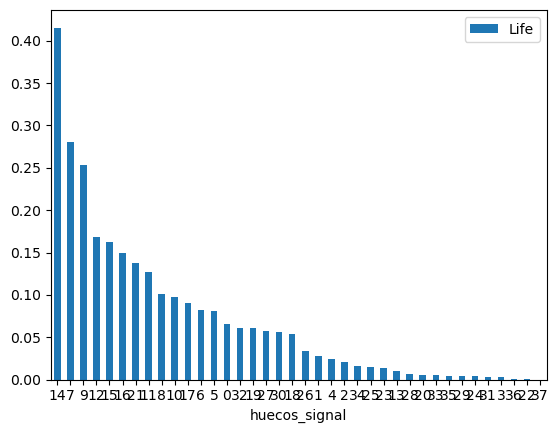

In [74]:
huecos_signal_top20 = huecos_signal.iloc[:50,:]
huecos_signal_top20.plot.bar(x='huecos_signal', y='Life', rot=0) #plot la persistencia de los huecos de la señal con ruido
plt.show()

In [31]:
#skeletonCirc_noise = gd.RipsComplex(points=y_embedded_noise, max_edge_length = 2)
#Rips_simplex_tree_Circ_noise = skeletonCirc_noise.create_simplex_tree(max_dimension = 2)
#Barcodes_Rips_Circ_noise = Rips_simplex_tree_Circ_noise.persistence()
#gd.plot_persistence_diagram(Barcodes_Rips_Circ_noise);
#plt.title(f'Persistence Diagram for signal with noise')
#plt.show()    

In [32]:
#diag_inf = Rips_simplex_tree_Circ_noise.persistence(min_persistence=0)
#gd.plot_persistence_barcode(diag_inf);
#plt.title(f'Persistence of Barcodes for noise')
#plt.show()

In [33]:
#skeletonCirc_signal = gd.RipsComplex(points=y_embedded_signal, max_edge_length = 2)
#Rips_simplex_tree_Circ_signal = skeletonCirc_signal.create_simplex_tree(max_dimension = 2)
#Barcodes_Rips_Circ_signal = Rips_simplex_tree_Circ_signal.persistence()
#gd.plot_persistence_diagram(Barcodes_Rips_Circ_signal);
#plt.title(f'Persistence Diagram for signal with no noise')
#plt.show()    

In [34]:
#diag_inf = Rips_simplex_tree_Circ_signal.persistence(min_persistence=0)
#gd.plot_persistence_barcode(diag_inf);
#plt.title(f'Persistence of Barcodes for signal')
#plt.show()

In [35]:
#barcodes
#simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
#Notemos con esta paquetería se queda con lo más significativo si cambiamos la persistencia
#diag0 = simplex_tree.persistence(min_persistence=0)
#gudhi.plot_persistence_barcode(diag0)
#plt.show()

### Generar vectores para 10 señales 

### Mapper